# Customer Churn Prediction and Analysis


This project aims to predict which customers are more likely to discontinue their subscription service, also known as churn prediction. Using the Telco Customer Churn dataset from Kaggle, I will apply data analysis techniques to classify customers as “returned” or “churned”. The dataset includes information regarding the customers’ demographics, the services they subscribed to, whether the customer left within the last month, and account information. The goal is to compare simple machine learning models with a deep learning approach to see which provides better predictions and business insights.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

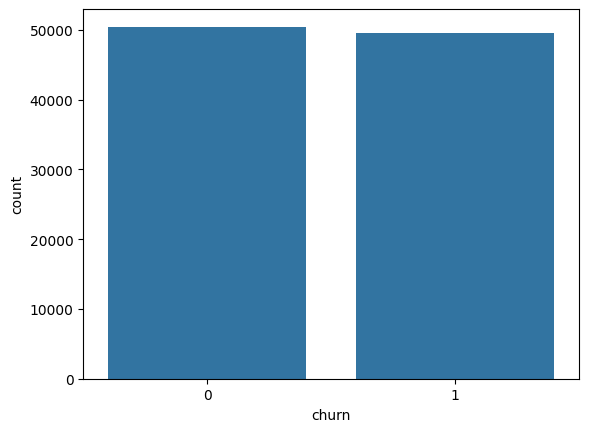

In [2]:
# 1. Loading the Dataset
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()
df.info()
sns.countplot(x='churn', data=df)
plt.show()

In [ ]:
# 2. Data preprocessing
df["churn"] = LabelEncoder().fit_transform(df["churn"])

# One-hot coding
df = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df.drop("churn", axis=1)
y = df["churn"]

# Create an imputer to replaces NaN with the column mean
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Features scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data preprocessing complete.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"NaN values? {pd.isna(X_train).any()}")

Data preprocessing complete.
Training set shape: (80000, 210)
Test set shape: (20000, 210)
=NaN values? False


Dataset shape: (100000, 211)

Data types:
rev_Mean       float64
mou_Mean       float64
totmrc_Mean    float64
da_Mean        float64
ovrmou_Mean    float64
ovrrev_Mean    float64
vceovr_Mean    float64
datovr_Mean    float64
roam_Mean      float64
change_mou     float64
dtype: object

Missing values per column:
numbcars       49366
lor            30190
income         25436
adults         23019
avg6rev         2839
avg6qty         2839
avg6mou         2839
rv              1732
forgntvl        1732
truck           1732
change_mou       891
change_rev       891
hnd_price        847
totmrc_Mean      357
ovrmou_Mean      357
dtype: int64


C:\Users\anhth\AppData\Local\Temp\ipykernel_10676\3758285823.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="churn", data=df, palette="coolwarm")


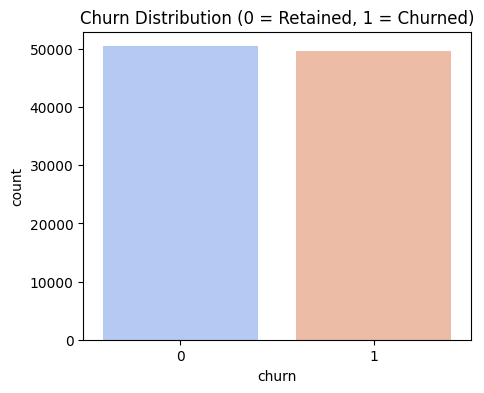

In [9]:
# 2.1. Data exploration
# Check dataset dimensions and types
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes.head(10))

# Look at missing values
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(15))

# Churn distribution
plt.figure(figsize=(5,4))
sns.countplot(x="churn", data=df, palette="coolwarm")
plt.title("Churn Distribution (0 = Retained, 1 = Churned)")
plt.show()

In [13]:
# 3. Baseline models
# Logistic Regression
lr = LogisticRegression(max_iter=1000, n_jobs=-1) #Use all CPU cores for parallel training
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    n_jobs=-1,      # use all CPU cores
    max_depth = 10) # limit tree depth to prevent overfitting
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# 3.1. Model evaluation
for name, preds in [('Logistic Regression', lr_preds), ('Random Forest', rf_preds)]:
    print(f"{name}")
    print(f"Accuracy: {accuracy_score(y_test, preds):.3f}")
    print(f"F1 Score: {f1_score(y_test, preds):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_test, preds):.3f}\n")


Logistic Regression
Accuracy: 0.592
F1 Score: 0.590
ROC AUC: 0.592

Random Forest
Accuracy: 0.617
F1 Score: 0.628
ROC AUC: 0.617



In [11]:
# 4. Deep Neural Network model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.3f}, Test AUC: {auc:.3f}")

c:\Users\anhth\OneDrive\Desktop\Fall25\ITMD 524\ChurnPrediction\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5491 - auc: 0.5668 - loss: 0.6994 - val_accuracy: 0.5851 - val_auc: 0.6188 - val_loss: 0.6731
Epoch 2/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5798 - auc: 0.6111 - loss: 0.6744 - val_accuracy: 0.5953 - val_auc: 0.6301 - val_loss: 0.6679
Epoch 3/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5928 - auc: 0.6300 - loss: 0.6668 - val_accuracy: 0.6016 - val_auc: 0.6407 - val_loss: 0.6642
Epoch 4/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - auc: 0.6369 - loss: 0.6636 - val_accuracy: 0.6053 - val_auc: 0.6459 - val_loss: 0.6620
Epoch 5/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6033 - auc: 0.6422 - loss: 0.6609 - val_accuracy: 0.6063 - val_auc: 0.6478 - val_loss: 0.6608
Epoch 6/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6053 - auc: 0.6487 - loss: 0.6581 - val_accuracy: 0.6094 - val_auc: 0.6494 - val_loss: 0.6596
Epoch 7/30
2000/2000 ━━━━━

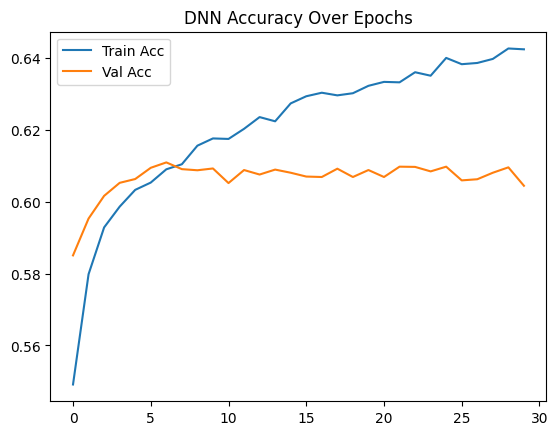

In [14]:
# 5. Model visualization
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('DNN Accuracy Over Epochs')
plt.show()

In [16]:
# 6. Save the models

import joblib

# Save models
joblib.dump(lr, "models/logistic_regression.pkl")
joblib.dump(rf, "models/random_forest.pkl")
model.save("models/dnn_model.keras")
